In [49]:
import xarray as xr
import netCDF4 as NC
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import LogNorm
from cmocean import cm
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

from scipy.interpolate import griddata, interpn
import scipy.stats as stat

In [56]:
path = f'/ocean/atall/MOAD/ObsModel/202111'
files = Path(path).glob('ObsModel_202111_bot_from_dfo2_*.csv')

dfs = list()
for f in files:
    data = pd.read_csv(f)
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,source,Year,Month,Day,Hour,Lat,Lon,Pressure,...,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_flagellates,mod_vosaline,mod_votemper,mod_dissolved_oxygen,k,file
0,0,10953,"req20181018/eo UBC October 18, 2018/2017-01-01...",2017.0,2.0,19.0,7.132222,48.5,-124.735667,1.0,...,11.305601,26.678005,0.497692,0.014719,0.237461,29.579924,7.992707,309.262695,0,ObsModel_202111_bot_from_dfo2_20170101_20171231
1,1,10954,"req20181018/eo UBC October 18, 2018/2017-01-01...",2017.0,2.0,19.0,7.132222,48.5,-124.735667,5.6,...,11.398505,26.822662,0.485588,0.014669,0.237199,29.652584,8.047593,308.641022,5,ObsModel_202111_bot_from_dfo2_20170101_20171231
2,2,10955,"req20181018/eo UBC October 18, 2018/2017-01-01...",2017.0,2.0,19.0,7.132222,48.5,-124.735667,9.9,...,11.838587,27.500669,0.472743,0.016324,0.241533,29.946798,8.178132,304.754669,9,ObsModel_202111_bot_from_dfo2_20170101_20171231
3,3,10956,"req20181018/eo UBC October 18, 2018/2017-01-01...",2017.0,2.0,19.0,7.132222,48.5,-124.735667,20.1,...,13.159301,29.177792,0.451306,0.017511,0.248634,30.706648,8.357696,294.019989,18,ObsModel_202111_bot_from_dfo2_20170101_20171231
4,4,10957,"req20181018/eo UBC October 18, 2018/2017-01-01...",2017.0,2.0,19.0,7.132222,48.5,-124.735667,30.0,...,13.358905,30.025820,0.425174,0.008288,0.242660,31.045183,8.339452,292.234955,21,ObsModel_202111_bot_from_dfo2_20170101_20171231


In [51]:
# Saanich Inlet values:
dfS=df.loc[(df.N>=0)&(df.P>=0)&(df.Lon>-123.65)&(df.Lon<-123.43)&(df.Lat>48.45)&(df.Lat<48.75)]
# SoG values
dfC=df.loc[(df.N>=0)&(df.P>=0)&(df.Lon>-124.)&(df.Lon<-123.59)&(df.Lat>49.25)&(df.Lat<49.44)]

In [52]:
# model bathymetry for plotting
with NC.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

Text(0.5, 1.0, 'Legend: red-Saanich Inlet, blue-SoG')

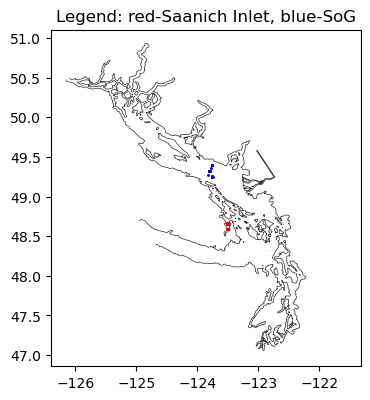

In [53]:
fig,ax=plt.subplots(1,1,figsize=(4,9))
contour_lines = ax.contour(bathylon,bathylat,bathyZ,[0,],
                colors='black',zorder=2,linewidths=.5,alpha=.8)
ax.set_aspect(1.3)
ax.plot(dfS.Lon,dfS.Lat,'r.',ms=1)
ax.plot(dfC.Lon,dfC.Lat,'b.',ms=1)
#ax.set_xlim(-123.65,-123.43)
#ax.set_ylim(48.45,48.8)
ax.set_title('Legend: red-Saanich Inlet, blue-SoG')

In [54]:
def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.25, 0.15, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

Text(0.5, 0.98, 'Strait of Georgia')

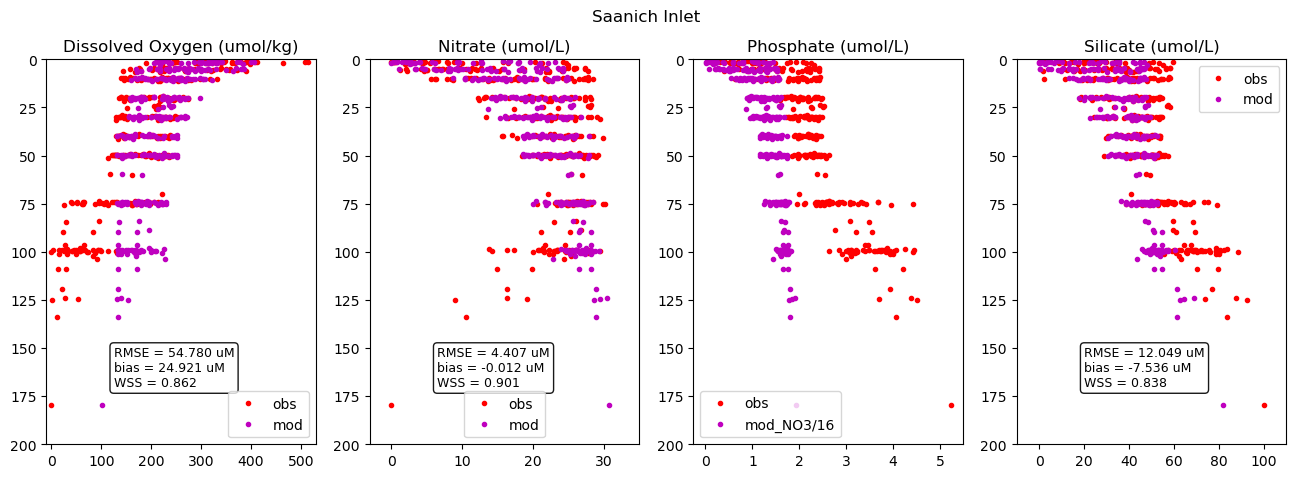

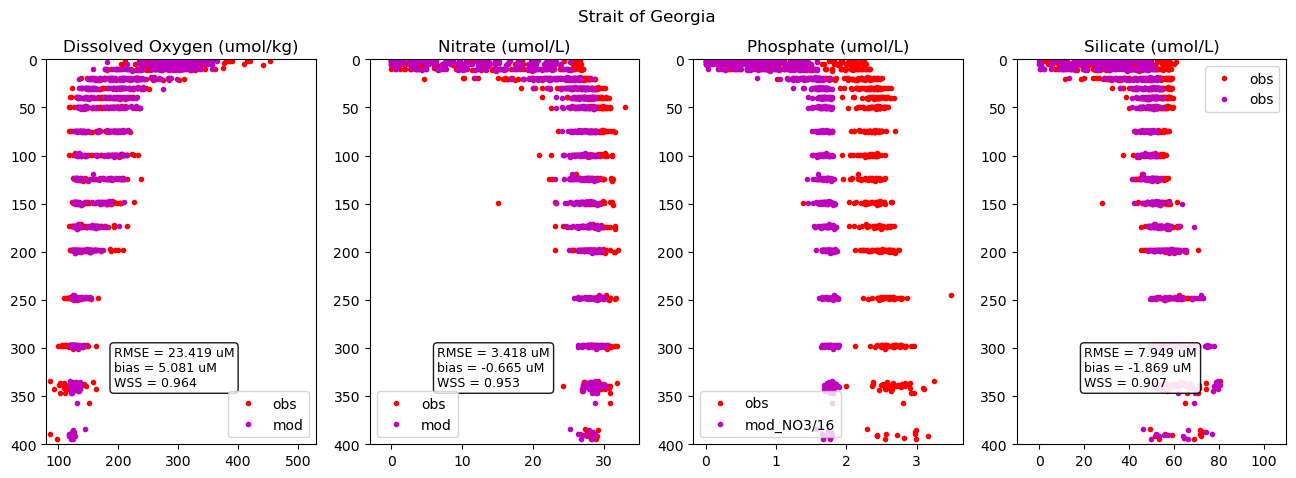

In [55]:
fig,ax=plt.subplots(1,4,figsize=(16,5))
ax[0].plot(dfS.O2_umolkg,dfS.Z,'r.',label='obs')
ax[0].plot(dfS.mod_dissolved_oxygen,dfS.Z,'m.',label='mod')
plot_panel(ax[0], dfS.O2_umolkg, dfS.mod_dissolved_oxygen, (-10,530), 'uM')
ax[0].set_ylim(200,0)
ax[1].plot(dfS.N,dfS.Z,'r.',label='obs')
ax[1].plot(dfS.mod_nitrate,dfS.Z,'m.',label='mod')
plot_panel(ax[1], dfS.N, dfS.mod_nitrate, (-3,35), 'uM')
ax[1].set_ylim(200,0)
ax[2].plot(dfS.P,dfS.Z,'r.',label='obs')
ax[2].plot(dfS.mod_nitrate/16,dfS.Z,'m.',label='mod_NO3/16')
ax[2].set_ylim(200,0)
ax[3].plot(dfS.Si,dfS.Z,'r.',label='obs')
ax[3].plot(dfS.mod_silicon,dfS.Z,'m.',label='mod')
plot_panel(ax[3], dfS.Si, dfS.mod_silicon, (-10,110), 'uM')
ax[3].set_ylim(200,0)
ax[0].set_title('Dissolved Oxygen (umol/kg)')
ax[1].set_title('Nitrate (umol/L)')
ax[2].set_title('Phosphate (umol/L)')
ax[3].set_title('Silicate (umol/L)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
fig.suptitle('Saanich Inlet')

fig,ax=plt.subplots(1,4,figsize=(16,5))
ax[0].plot(dfC.O2_umolkg,dfC.Z,'r.',label='obs')
ax[0].plot(dfC.mod_dissolved_oxygen,dfC.Z,'m.',label='mod')
plot_panel(ax[0], dfC.O2_umolkg, dfC.mod_dissolved_oxygen, (80, 530), 'uM')
ax[0].set_ylim(400,0)
ax[1].plot(dfC.N,dfC.Z,'r.',label='obs')
ax[1].plot(dfC.mod_nitrate,dfC.Z,'m.',label='mod')
plot_panel(ax[1], dfC.N, dfC.mod_nitrate, (-3,35), 'uM')
ax[1].set_ylim(400,0)
ax[2].plot(dfC.P,dfC.Z,'r.',label='obs')
ax[2].plot(dfC.mod_nitrate/16,dfC.Z,'m.',label='mod_NO3/16')
ax[2].set_ylim(400,0)
ax[3].plot(dfC.Si,dfC.Z,'r.',label='obs')
ax[3].plot(dfC.mod_silicon,dfC.Z,'m.',label='obs')
plot_panel(ax[3], dfC.Si, dfC.mod_silicon, (-10,110), 'uM')
ax[3].set_ylim(400,0)
ax[0].set_title('Dissolved Oxygen (umol/kg)')
ax[1].set_title('Nitrate (umol/L)')
ax[2].set_title('Phosphate (umol/L)')
ax[3].set_title('Silicate (umol/L)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
fig.suptitle('Strait of Georgia')